# Toy Example over longer timescales


We have a general, simple pipeline as follows:
```

config.py


download_CDS.py                        download_MODIS.py                
     ↓                                        ↓
     ↓                                        ↓
     ↓                                        ↓
     ↓                                        ↓
     ↓                                        ↓
     ↳→→→→→→→→→→→→ clean_all_data.py ←←←←←←←←←↲
                        ↓
               [dataframe: 'cleaned_data.pkl']
                        ↓
                        ↓
                      ML.py
                        ↓
                        ↓
             [      model: trained_model.joblib ]
             [  dataframe: predictions.pkl      ]       
```
---

* Global settings are specified in `config.py`

* The X data is handled well by `climetlab` and the CDS API.
* The Y data is obtained through a `wget` call to MODIS 

* The X and Y data are then brought together month-by-month (`clean_all_data.py`) into a single df via an inner join, after some relabelling of columns, indexing, long1/3 conversions etc. This single df is saved as a pickle and will be the basis of all ML training/predictions.

* ML trainining, hyperparameter optimisation and prediciton is performed in `ML.py`



---




In [80]:
import pandas as pd
data_root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/'
f = 'predictions.pkl'

#Load the df of predictions and true values
df = pd.read_pickle(data_root+f)   

#Also create an xr dataset object
xr_dataset=xr.Dataset.from_dataframe(df) 


In [262]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import sys

    
def plot_to_subplot(f,ax,y,fixed_scaling):  
    quadmesh = f[y].plot(ax=ax, 
                             cmap='jet',
                             transform=ccrs.PlateCarree(),
                              cbar_kwargs={'orientation':'vertical','shrink':0.6, 'aspect':40})    
    ax.coastlines()
    
   
    if fixed_scaling:
        quadmesh.set_clim(vmin=10000, vmax=17000)

    

def plot_month_map(f,i):
    
    #Plot the predictions, the truth and the relative error for the ith month as a map 
    #i=1 is first month, etc.

    #Time slice
    fmonth = f.isel(time=i-1)
    

    #Set up figure and axes
    h,w = 24,12
    fig = plt.figure(figsize=(h,w))
    ax1 = plt.subplot2grid((3, 2),(0,0),projection=ccrs.PlateCarree(central_longitude=0))
    ax2 = plt.subplot2grid((3, 2),(0,1),sharey=ax1,projection=ccrs.PlateCarree(central_longitude=0))
    ax3 = plt.subplot2grid((3, 2),(1,0),colspan=2,rowspan=2,projection=ccrs.PlateCarree(central_longitude=0))


    #Plot it 
    plot_to_subplot(fmonth,ax1,'LST_Day_CMG',True)
    plot_to_subplot(fmonth,ax2,'predictions',True)
    plot_to_subplot(fmonth,ax3,'relative_error',False)


                
        
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    

    
def get_errors(df):
    max_error = np.max(abs(df['relative_error']))
    min_error = np.min(abs(df['relative_error']))
    mean_error = np.mean(abs(df['relative_error']))
    
    return max_error, min_error, mean_error
    
def evaluate_month(df,i):
    
    times_index = np.unique(df.index.get_level_values('time').values)
    df_month = df.loc[(slice(None), slice(None),times_index[i-1]), :]
    
    
    max_error, min_error, mean_error = get_errors(df_month)
    print (times_index[i-1], min_error, max_error, mean_error)
    


We can grab how good the predicions were for a single month:

2019-01-01T00:00:00.000000000 0.0 0.1265522818367204 0.014626712396861174


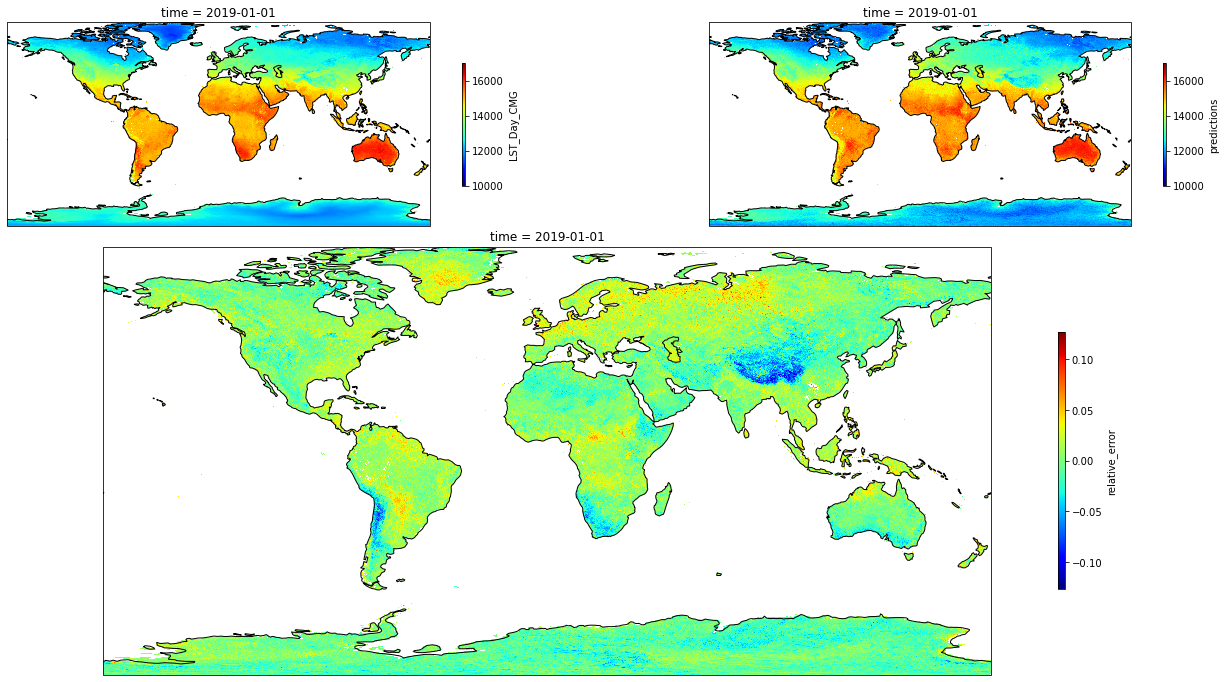

In [261]:
i = 1
plot_month_map(xr_dataset,i)
evaluate_month(df,i)

And can grab the overall error over the entire prediction set (max/min/mean): 

In [264]:
get_errors(df)

(0.23042459208509875, 0.0, 0.014638881354106518)

# Appendix

# # Questions

* What features do we have access to when actually running our models? 

* What about warm vs control climates? Are there values in warm climates that are not observed in warm climates? i.e. does our training data cover the whole parameter space?

* How accurate do we need to be? Mean error vs worst case error?

## Getting the X data 

Features are obtained via the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview).

In particular, we use the ERA5-Land monthly averaged data, which ranges from 1981 to present.

We access this data via the [climetlab](https://climetlab.readthedocs.io/en/latest/index.html) package, which in turn uses the [CDS API](https://pypi.org/project/cdsapi/)

Queries to CDS are queued and can take a long time (think hours rather than minutes).

## Getting the Y data
Outputs in this case are LST values from [MODIS](https://modis-land.gsfc.nasa.gov/temp.html).

In particular we use the CMG (Climate Modelling Grid) product on a monthly timescale [MOD11C3](https://lpdaac.usgs.gov/products/mod11c3v006/).

We can access this MODIS data via HTTPS queries of the [Data Pool](https://lpdaac.usgs.gov/tools/data-pool/). [See the docs](https://lpdaac.usgs.gov/resources/e-learning/how-access-lp-daac-data-command-line/) for a more indepth discussion on how to do this. 